In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
pd.set_option('display.max_columns',None)



from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly

sns.set(style='whitegrid')
plt.rcParams['figure.figsize']=(15,5)
%config InlineBackend.figure_format = 'png'
%matplotlib inline

Грузим данные 

In [2]:
df_march = pd.read_csv('./data/2_march.csv', sep=';')
df_apr = pd.read_csv('./data/2_april.csv', sep=';')
df_may = pd.read_csv('./data/2_may.csv', sep=';')
df_checks  = pd.concat([df_march, df_apr, df_may], axis=0)



In [3]:

df_points = pd.read_csv('./data/projects for TT.csv', sep=';')
df_left = pd.read_csv('./data/2_ost.csv', sep=';')

In [4]:
df_shops = pd.read_csv('./data/svao_info.csv', sep=';')

Выделяем признаки 

In [5]:
date = pd.to_datetime(df_checks['date_ch'])
df_checks['day'] = date.dt.day
df_checks['year'] = date.dt.year
df_checks['month'] = date.dt.month
df_checks['week'] = date.dt.week
df_checks['day_of_week'] = date.dt.day_name()

df_checks['hour'] = df_checks['time_ch'].apply(lambda x: x.split(':')[0]).astype(int)
df_checks['time'] = df_checks['time_ch'].apply(lambda x: x.split(':')[1]).astype(int)

C:\Temp\ipykernel_3896\315077176.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_checks['week'] = date.dt.week


In [6]:
df_checks['BaseSum'] = df_checks['BaseSum'].round(decimals = 2)

Создаем таблицу категорий

In [7]:
df_category = df_left.groupby(['id_group','name_gr','id_group2','name_gr2','id_tov','name_tov']).agg({'date_tt':['count']})
df_category = df_category.reset_index()

Создаем таблицу с чеками и описанием категорий

In [8]:
df_checks_short = df_checks[['id_tt_cl','id_tov_cl','Quantity','date_ch','BaseSum']].copy()
df_checks_short['BaseSum'] = df_checks_short['BaseSum'].round(decimals = 2)
df_checks_with_cat = pd.merge(df_checks_short,df_category[['name_gr','id_tov']],left_on='id_tov_cl',right_on='id_tov',how = 'left')

C:\Temp\ipykernel_3896\3786797364.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_checks_with_cat = pd.merge(df_checks_short,df_category[['name_gr','id_tov']],left_on='id_tov_cl',right_on='id_tov',how = 'left')


Создаем Pivot таблицу с продажами

In [9]:
df_pivot_table = df_checks.pivot_table(columns=['week'], index=['id_tt_cl'], values = ['BaseSum']).pct_change(axis=1)

Выделяем плохие и хорошие магазины на основе изменения продаж в этом магазине на неделе по сравнению с общей динамикой

In [10]:
df_week_diff = df_pivot_table - df_pivot_table.median()

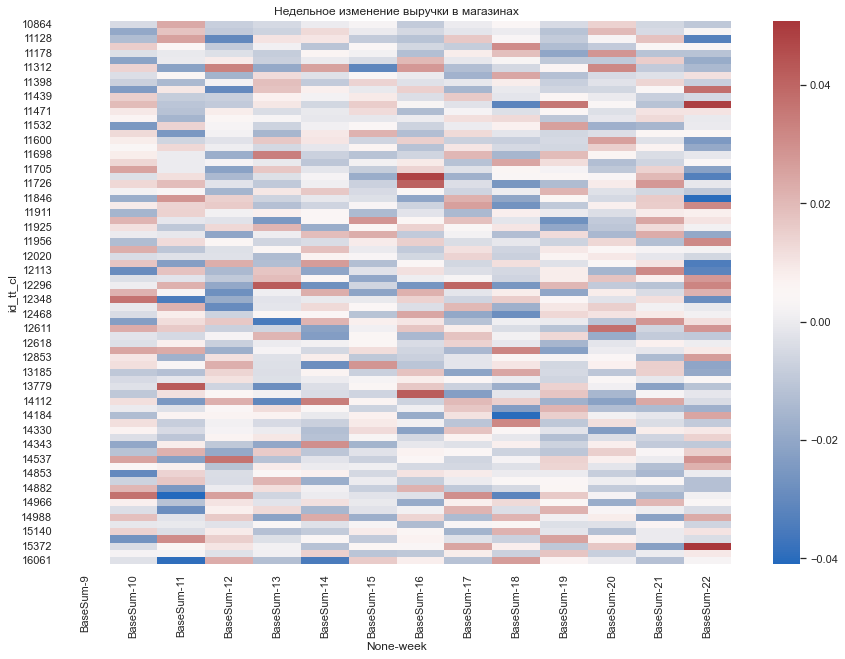

In [11]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_week_diff, cmap='vlag')
plt.title('Недельное изменение выручки в магазинах');

Считаем камулятивное увеличение выручки в магазине в течении всего срока

In [12]:
df_week_diff_cum = (df_pivot_table - df_pivot_table.median()).cumsum(axis=1)

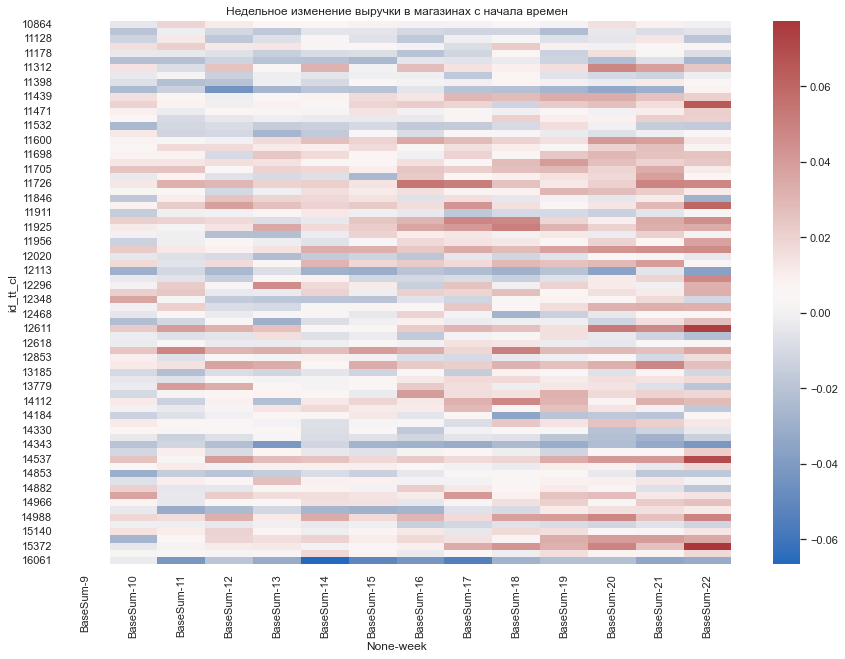

In [13]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_week_diff_cum, cmap='vlag')
plt.title('Недельное изменение выручки в магазинах с начала времен');

In [14]:
df_checks.to_pickle("./df_checks.pkl")



In [15]:
df_shops.to_pickle("./df_shops.pkl")
df_points.to_pickle("./df_points.pkl")
df_left.to_pickle("./df_left.pkl")

In [16]:
df_category.to_pickle("./df_category.pkl")
df_checks_with_cat.to_pickle("./df_checks_with_cat.pkl")
df_pivot_table.to_pickle("./df_pivot_table.pkl")
df_week_diff.to_pickle("./df_week_diff.pkl")
df_week_diff_cum.to_pickle("./df_week_diff_cum.pkl")

In [17]:
df_target = (df_pivot_table - df_pivot_table.median()).sum(axis=1)

Добавляем качество к магазинам 

In [18]:
df_target4 = pd.DataFrame(df_target.tolist(),columns=['quality'])
df_shops = pd.concat([df_shops,df_target4], axis=1)
del df_target4

In [19]:
df_target[df_target<0] = -1
df_target[(df_target<0.025103) & (df_target>0)] = 0
df_target[df_target>=0.025103] = 1

In [20]:
df_target = df_target.reset_index()


In [21]:
df_target.columns = ['id_tt', 'good_or_bad']

In [22]:
df_target

,id_tt,good_or_bad
0,10864,-1.0
1,11127,-1.0
2,11128,-1.0
3,11160,0.0
4,11178,-1.0
...,...,...
70,15140,0.0
71,15194,1.0
72,15372,1.0
73,15714,0.0


In [23]:
df_shops = df_shops.merge(df_target,how='left', on='id_tt')

In [24]:
df_shops.columns

Index(['id_tt', 'adress', 'Hours', 'Shirota', 'Dolgota', 'ploshad', 'city_tt',
       'Район', 'shtat', 'qty_kassa', 'qty_kassa_so', 'format', 'quality',
       'good_or_bad'],
      dtype='object')

In [25]:
df_shops.to_pickle("./df_shops.pkl")